In [1]:
from numba import jit
import numpy as np
import time
import timeit
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import torch

In [ ]:
def removeFloat(film): # fast scanZ
    
    # 获取当前平面与前后平面的布尔索引
    current_plane = film != 0

    # 获取周围邻居的布尔索引
    neighbors = torch.zeros_like(film, dtype=torch.bool)
    
    neighbors[1:, :, :] &= film[:-1, :, :] == 0  # 上面
    neighbors[:-1, :, :] &= film[1:, :, :] == 0  # 下面
    neighbors[:, 1:, :] &= film[:, :-1, :] == 0  # 左边
    neighbors[:, :-1, :] &= film[:, 1:, :] == 0  # 右边
    neighbors[:, :, 1:] &= film[:, :, :-1] == 0  # 前面
    neighbors[:, :, :-1] &= film[:, :, 1:] == 0  # 后面
    
    # 获取满足条件的索引
    condition = current_plane & neighbors
    
    # 更新表面稀疏张量
    film[condition] = 0
    
    return film

In [2]:
@jit(nopython=True)
def SpecularReflect(vel, normal):
    NewVwl =  vel - 2*vel@normal*normal
    return NewVwl


vel = np.array([-1, 0, -1], dtype=float)

theta = np.array([-1, 0, 0], dtype=float)

# theta = np.random.rand(3)
# vel = np.random.rand(3)
SpecularReflect(vel, theta)

array([ 1.,  0., -1.])

In [64]:
react_table = np.array([[[0.700, 0, 1], [0.300, 0, 1]],
                        [[0.200, -1, 0], [0.075, 0, -1]]])

@jit(nopython=True)
def SpecularReflect(vel, normal):
    return vel - 2*vel@normal*normal

# etching act on film, depo need output
@jit(nopython=True)
def reaction_yield(parcel, film, theta):
    num_parcels = parcel.shape[0]
    num_reactions = react_table.shape[1]
    choice = np.random.rand(parcel.shape[0], react_table.shape[1])
    reactList = np.ones(parcel.shape[0])*-1
    for i in range(num_parcels):
        for j in range(num_reactions):
            if film[i, j] <= 0:
                choice[i, j] = 1
    depo_parcel = np.zeros(parcel.shape[0])
    for i in range(parcel.shape[0]):
        acceptList = np.zeros(react_table.shape[1], dtype=np.bool_)
        for j in range(film.shape[1]):
            react_rate = react_table[int(parcel[i, -1]), j, 0]
            if react_rate > choice[i, j]:
                acceptList[j] = True
        react_choice_indices = np.where(acceptList)[0]
        if react_choice_indices.size > 0:
            react_choice = np.random.choice(react_choice_indices)
            reactList[i] = react_choice
            if np.sum(react_table[int(parcel[i, -1]), react_choice, 1:]) > 0:
                depo_parcel[i] = 1
            if np.sum(react_table[int(parcel[i, -1]), react_choice, 1:]) < 0:
                depo_parcel[i] = -1
    for i in range(parcel.shape[0]):
        if depo_parcel[i] == -1:
            film[i, :] += 0.01 * react_table[int(parcel[i, -1]), int(reactList[i]), 1:]
        if reactList[i] == -1:
            parcel[i,3:6] = SpecularReflect(parcel[i,3:6], theta[i])

    return film, parcel, reactList, depo_parcel


film = np.zeros((10, 2))

film[:, 0] = 0.5
film[:, 1] = 0.5
print(film)
# parcel = np.random.choice(2, size=10)
# particle data struction np.array([posX, posY, posZ, velX, velY, velZ, i, j, k, typeID])
# parcel = np.ones(10, dtype=int)
parcel = np.ones((10, 10))
parcel[:5, -1] = 0
print(parcel)
# test1 = UnitTest(parcel, film)
# print(test1.testReact())
theta = np.random.rand(30).reshape(10,3)
film, parcel, reactList, depo_parcel = reaction_yield(parcel, film, theta)

print('-------------')
print(film)

print('---------------')
print('reactList',reactList)
print('depoparcel', depo_parcel)
print('parcel', parcel[:, -1])

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
-------------
[[0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.49 0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]]
---------------
reactList [ 0.  0. -1.  0.  0.  0. -1. -1. -1. -1.]
depoparcel [ 1.  1.  0.  1.  1. -1.  0.  0.  0.  0.]
parcel [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


In [57]:
np.where(reactList != -1)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),)

In [44]:
react_table = np.array([[[0.700, 0, 1], [0.300, 0, 1]],
                        [[0.200, -1, 0], [0.075, 0, -1]]])

# etching act on film, depo need output
@jit(nopython=True)
def reaction_yield(parcel, film):
    num_parcels = parcel.shape[0]
    num_reactions = react_table.shape[1]
    choice = np.random.rand(parcel.shape[0], react_table.shape[1])
    # print('choice', choice)
    reactList = np.ones(parcel.shape[0])*-1
    indiceFilm = film == 0
    # print(indiceFilm.shape)
    # choice[indiceFilm] = 0

    for i in range(num_parcels):
        for j in range(num_reactions):
            if film[i, j] <= 0:
                choice[i, j] = 1

    # print('choice', choice)   

    depo_parcel = np.zeros(parcel.shape[0])
    for i in range(parcel.shape[0]):
        acceptList = np.zeros(react_table.shape[1], dtype=np.bool_)
        for j in range(film.shape[1]):
            react_rate = react_table[parcel[i], j, 0]
            if react_rate > choice[i, j]:
                acceptList[j] = True
        # print( 'react_table',react_table[parcel[i], :, 0])
        # # print(choice[i])
        # print('accept',acceptList)  
        # react_choice_indices = np.random.choice(int(np.sum(acceptList)))
        react_choice_indices = np.where(acceptList)[0]
        print( 'react_choice_indices', react_choice_indices)
        if react_choice_indices.size > 0:
            react_choice = np.random.choice(react_choice_indices)
            reactList[i] = react_choice
            # film[i, react_choice] -= 0.01      # left
            # print('react type', react_table[parcel[i], react_choice, 1:])
            if np.sum(react_table[parcel[i], react_choice, 1:]) > 0:
                depo_parcel[i] = 1
            if np.sum(react_table[parcel[i], react_choice, 1:]) < 0:
                depo_parcel[i] = -1


            etching_pick = np.where(depo_parcel == -1)
            # film[i, :] += 0.01*react_table[parcel[i], react_choice, 1:]   # right
    for i in range(parcel.shape[0]):
        if depo_parcel[i] == -1:
            film[i, :] += 0.01 * react_table[parcel[i], int(reactList[i]), 1:]
    # film[etching_pick, :] += 0.01*react_table[parcel[etching_pick], react_choice, 1:]
            # react_gen = react_table[parcel[i], react_choice, 1]
            # if react_gen > 0:
            #     film[i, int(react_gen)-1] += 0.01
            # else:
            #     parcelGen[i] = -react_gen
                
    return film, reactList, depo_parcel


film = np.zeros((10, 2))

film[:, 0] = 0.5
film[:, 1] = 0.5
print(film)
# parcel = np.random.choice(2, size=10)
parcel = np.ones(10, dtype=int)
parcel[:5] = 0
print(parcel)
# test1 = UnitTest(parcel, film)
# print(test1.testReact())
film, reactList, depo_parcel = reaction_yield(parcel, film)

print('-------------')
print(film)

print('---------------')
print('reactList',reactList)

print('depoparcel', depo_parcel)

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
[0 0 0 0 0 1 1 1 1 1]
react_choice_indices [0]
react_choice_indices []
react_choice_indices [0]
react_choice_indices [1]
react_choice_indices []
react_choice_indices []
react_choice_indices []
react_choice_indices [0]
react_choice_indices [0]
react_choice_indices []
-------------
[[0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.49 0.5 ]
 [0.49 0.5 ]
 [0.5  0.5 ]]
---------------
reactList [ 0. -1.  0.  1. -1. -1. -1.  0.  0. -1.]
depoparcel [ 1.  0.  1.  1.  0.  0.  0. -1. -1.  0.]


In [10]:
# 定义反应表和初始的 film 元素
react_table = np.array([[[0.700, 0, 1], [0.300, 0, 1]],
                        [[0.200, -1, 0], [0.075, 0, -1]]])
# film_elemnt = np.array([1, 0], dtype=float)
film_elemnt = np.array([10, 20], dtype=float)
def reaction(gas, film):
    # 计算总长度
    total_length = int(film.sum())

    # 预分配反应类型和反应速率
    reaction_type = np.empty(total_length, dtype=int)
    reaction_rate = np.empty(total_length, dtype=float)

    # 填充反应类型和反应速率
    current_index = 0
    for i in range(film.shape[0]):
        length = int(film[i])
        reaction_type[current_index:current_index + length] = i
        reaction_rate[current_index:current_index + length] = react_table[gas, i, 0]
        current_index += length

    # 生成随机数列以确定反应发生的概率
    reaction_list = np.random.rand(total_length)

    # 筛选出发生反应的粒子
    reaction_indices = np.where(reaction_rate > reaction_list)[0]
    
    # 如果有反应发生，随机选择一个反应
    if reaction_indices.size > 0:
        reaction_choice = np.random.choice(reaction_indices, 1)
        reaction_particle = reaction_type[reaction_choice][0]
        # print(reaction_particle)
        # 更新 film 元素的状态
        filmAddtion = np.array(react_table[gas, reaction_particle, 1:], dtype=int)
        return filmAddtion, reaction_particle, np.sum(react_table[gas, reaction_particle, 1:]) # film, react_type, etchingDepo 
    else:
        return np.zeros_like(film), -1, 0
    

print(reaction(0, film_elemnt))

(array([0, 1]), 1, 1.0)


In [424]:
#react_t g[Cu]   s  [1,     2]
#react_t g[Cu] g\s  [Si,   Cu]
            #  Cu    0.7,  0.3   
            #  Ar    0.2   0.075
react_table = np.array([[[0.7, 1, 2], [0.3, 0, 2]],
                        [[0.2, -1, 0], [0.075, 0, -1]]])


@jit(nopython=True)
def reaction(parcel, film):
    num_parcels = parcel.shape[0]
    num_reactions = react_table.shape[1]
    choice = np.random.rand(num_parcels, num_reactions)
    print(choice.shape)
    indiceFilm = film == 0
    print(indiceFilm.shape)
    # choice[indiceFilm] = 0

    # Indicate if the film is zero
    for i in range(num_parcels):
        for j in range(num_reactions):
            if film[i, j] == 0:
                choice[i, j] = 1


    print(choice)
    parcelGen = np.zeros(num_parcels)
    reactList = np.zeros(num_parcels)

    for i in range(num_parcels):
        acceptList = react_table[parcel[i], :, 0]/choice[i] > 1
        print(react_table[parcel[i], :, 0])
        print(choice[i])
        print(acceptList)
        react_choice_indices = np.where(acceptList)[0]
        # print(react_choice_indices)
        if react_choice_indices.size > 0:
            react_choice = np.random.choice(react_choice_indices)
            reactList[i] = react_choice
            film[i, react_choice] -= 0.01
            react_gen = react_table[parcel[i], react_choice, 1]
            if react_gen > 0:
                film[i, int(react_gen) - 1] += 0.01
            else:
                parcelGen[i] = -react_gen
    
    return film, parcelGen, reactList

class UnitTest:
    def __init__(self, parcel, film):
        self.parcel = parcel
        self.film = film
    
    def testReact(self):
        film, parcelGen, reactList = reaction(self.parcel, self.film)
        return film, parcelGen, reactList

film = np.zeros((10, 2))

film[:5, 0] = 1
film[5:, 1] = 1
print(film)
parcel = np.random.choice(3, size=10)
print(parcel)
# test1 = UnitTest(parcel, film)
# print(test1.testReact())
film, parcelGen, reactList = reaction(parcel, film)

print('-------------')
print(film)
print('-------------')
print(parcelGen)
print('---------------')
print(reactList)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[2 0 2 1 1 0 2 1 0 0]
(10, 2)
(10, 2)
[[0.87371415 1.        ]
 [0.73144343 1.        ]
 [0.39864057 1.        ]
 [0.64276348 1.        ]
 [0.0105777  1.        ]
 [1.         0.70438947]
 [1.         0.04220356]
 [1.         0.20144074]
 [1.         0.89120776]
 [1.         0.03815122]]
[0.7 0.3]
[0.87371415 1.        ]
[ True False]
[0.7 0.3]
[0.73144343 1.        ]
[False False]
[0.7 0.3]
[0.39864057 1.        ]
[ True False]
[0.2   0.075]
[0.64276348 1.        ]
[False False]
[0.2   0.075]
[0.0105777 1.       ]
[ True False]
[0.7 0.3]
[1.         0.70438947]
[False False]
[0.7 0.3]
[1.         0.04220356]
[ True False]
[0.2   0.075]
[1.         0.20144074]
[False False]
[0.7 0.3]
[1.         0.89120776]
[False False]
[0.7 0.3]
[1.         0.03815122]
[False  True]
-------------
[[ 0.99  0.  ]
 [ 1.    0.  ]
 [ 0.99  0.  ]
 [ 1.    0.  ]
 [ 0.99  0.  ]
 [ 0.    1.  ]
 [-0.01  1.  ]
 [ 0.    1.

In [423]:
0.7 > 0.7196888 

False

In [397]:
@jit(nopython=True)
def testnumba1():
    film = np.zeros((10, 2))

    film[:5, 0] = 1
    film[5:, 1] = 1
    print(film)

    indiceFilm = film == 0
    return indiceFilm

testnumba1()

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


array([[False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False]])

In [29]:
react_table3 = np.array([[[0.5, 2], [0.5, 3], [0.5, 4], [0.9, -4], [0.5, 7], [0.0, 0], [0.5, 8], [0.0, 0], [0.6, 10], [0.0, 0]],
                        [[0.5, 5], [0.0, 0], [0.0, 0], [0.0, 0], [0.5, 6], [0.0, 0], [0.0, 0], [0.0, 0], [0.0, 0], [0.0, 0]],
                        [[0.27, -1], [0.27, -2], [0.27, -3], [0.27, -4], [0.27, -5], [0.27, -6], [0.27, -7], [0.27, -8], [0.27, -9], [0.27, -10]]])


print(react_table3.shape)

react_table = np.zeros((3, 10, 11))

for i in range(react_table3.shape[0]):
    for j in range(react_table3.shape[1]):
        for k in range(react_table3.shape[2]):
            react_table[i, j, 0] = react_table3[i, j, 0]
            react_table[i, j, j+1] = -1
            react_chem =  int(np.abs(react_table3[i, j, 1]))
            if react_table3[i, j, 1] > 0:
                react_plus_min = 1
            elif react_table3[i, j, 1] < 0:
                react_plus_min = -1
            elif react_table3[i, j, 1] == 0:
                react_plus_min = 0
            react_table[i, j, react_chem] = react_plus_min

(3, 10, 2)


In [35]:
react_table[0, 3, 4] = -2

In [37]:
react_table[0, 2]

array([ 0.5,  0. ,  0. , -1. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

In [39]:
react_table[2, 3]

array([ 0.27,  0.  ,  0.  ,  0.  , -1.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ])

In [7]:
#solid = film[i, j, k, 10][Si, SiF1, SiF2, SiF3, SiO SiO2, SiOF, SiOF2, SiO2F, SiO2F2]
#react_t g[Cu] s  [1,         2]
#react_t g[Cu] s  [Cu,       Si]

# react_table = np.array([[[0.700, 0, 1], [0.300, 0, 1]],
#                         [[0.200, -1, 0], [0.075, 0, -1]]])

#solid = film[i, j, k, 10][Si, SiF1, SiF2, SiF3, SiO SiO2, SiOF, SiOF2, SiO2F, SiO2F2]
#react_t g[F, O, ion] s  [1,          2,           3,          4,       5 ,   6,    7,    8,   9,  10]
#react_t g[F, O, ion] s  [Si,       SiF1,       SiF2,       SiF3,      SiO, SiO2, SiOF, SiOF2, SiO2F,SiO2F2]

react_table = np.array([[[0.01, 2], [0.01, 3], [0.01, 4], [0.01, -4], [0.05, 7], [0.00, 0], [0.05, 8], [0.00, 0], [0.06, 10], [0.00, 0]],
                        [[0.05, 5], [0.00, 0], [0.00, 0], [0.00, 0], [0.05, 6], [0.00, 0], [0.00, 0], [0.00, 0], [0.00, 0], [0.00, 0]],
                        [[0.27, -1], [0.27, -2], [0.27, -3], [0.27, -4], [0.27, -5], [0.27, -6], [0.27, -7], [0.27, -8], [0.27, -9], [0.27, -10]]])


In [452]:
#solid = film[i, j, k, 10][Si, SiF1, SiF2, SiF3, SiO SiO2, SiOF, SiOF2, SiO2F, SiO2F2]
#react_t g[F, O, ion] s  [1,          2,           3,          4,       5 ,   6,    7,    8,   9,  10]
#react_t g[F, O, ion] s  [Si,       SiF1,       SiF2,       SiF3,      SiO, SiO2, SiOF, SiOF2, SiO2F,SiO2F2]

react_table = np.array([[[0.01, 2], [0.01, 3], [0.01, 4], [0.01, -4], [0.05, 7], [0.00, 0], [0.05, 8], [0.00, 0], [0.06, 10], [0.00, 0]],
                        [[0.05, 5], [0.00, 0], [0.00, 0], [0.00, 0], [0.05, 6], [0.00, 0], [0.00, 0], [0.00, 0], [0.00, 0], [0.00, 0]],
                        [[0.27, -1], [0.27, -2], [0.27, -3], [0.27, -4], [0.27, -5], [0.27, -6], [0.27, -7], [0.27, -8], [0.27, -9], [0.27, -10]]])

@jit(nopython=True)
def reaction(parcel, film):
    choice = np.random.rand(parcel.shape[0], react_table.shape[1])
    parcelGen = np.zeros(parcel.shape[0])
    reactList = np.zeros(parcel.shape[0])
    for i in range(parcel.shape[0]):
        acceptList = np.zeros(react_table.shape[1], dtype=np.bool_)
        
        for j in range(film.shape[1]):
            react_rate = react_table[parcel[i], j, 0]
            if react_rate > choice[i, j]:
                acceptList[j] = True
        
        # react_choice_indices = np.random.choice(int(np.sum(acceptList)))
        react_choice_indices = np.where(acceptList)[0]
        # print(react_choice_indices)
        if react_choice_indices.size > 0:
            react_choice = np.random.choice(react_choice_indices)
            reactList[i] = react_choice
            film[i, react_choice] -= 0.01
            react_gen = react_table[parcel[i], react_choice, 1]
            if react_gen > 0:
                film[i, int(react_gen)-1] += 0.01
            else:
                parcelGen[i] = -react_gen
                
    return film, parcelGen, reactList



class UnitTest:
    def __init__(self, parcel, film):
        self.parcel = parcel
        self.film = film
    
    def testReact(self):
        film, parcelGen, reactList = reaction(self.parcel, self.film)
        return film, parcelGen, reactList


film = np.zeros((10, 10))
parcel = np.random.choice(3, size=10)
print(parcel)
# test1 = UnitTest(parcel, film)
# print(test1.testReact())
film, parcelGen, reactList = reaction(parcel, film)
print(film)
print('-------------')
print(parcelGen)
print('---------------')
print(reactList)

[2 2 1 0 1 1 0 1 2 1]
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.01  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.01  0.    0.01  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.01  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
-------------
[0. 5. 0. 0. 0. 0. 0. 0. 8. 0.]
---------------
[0. 4. 0. 0. 0. 0. 4. 0. 7. 0.]


In [124]:
film = np.zeros((1000, 10))
parcel = np.random.choice(3, size=1000)

test1 = UnitTest(parcel, film)
test1.testReact()
numba_time = timeit.timeit(lambda: test1.testReact(), number=100)
print(f"Numba time: {numba_time:.6f} seconds")

Numba time: 1.360035 seconds


In [147]:
film = np.zeros((100, 10))
parcel = np.random.choice(3, size=100)

test1 = UnitTest(parcel, film)
test1.testReact()
numba_time = timeit.timeit(lambda: test1.testReact(), number=10000)
print(f"Numba time: {numba_time:.6f} seconds")


Numba time: 0.320966 seconds


In [385]:
react_table = np.array([[[0.01, 2], [0.01, 3], [0.01, 4], [0.01, -4], [0.05, 7], [0.00, 0], [0.05, 8], [0.00, 0], [0.06, 10], [0.00, 0]],
                        [[0.05, 5], [0.00, 0], [0.00, 0], [0.00, 0], [0.05, 6], [0.00, 0], [0.00, 0], [0.00, 0], [0.00, 0], [0.00, 0]],
                        [[0.27, -1], [0.27, -2], [0.27, -3], [0.27, -4], [0.27, -5], [0.27, -6], [0.27, -7], [0.27, -8], [0.27, -9], [0.27, -10]]])

@jit(nopython=True)
def reaction(parcel, film):
    num_parcels = parcel.shape[0]
    num_reactions = react_table.shape[1]
    choice = np.random.rand(num_parcels, num_reactions)
    parcelGen = np.zeros(num_parcels)
    reactList = np.zeros(num_parcels)

    for i in range(num_parcels):
        acceptList = react_table[parcel[i], :, 0] > choice[i]
        react_choice_indices = np.where(acceptList)[0]
        # print(react_choice_indices)
        if react_choice_indices.size > 0:
            react_choice = np.random.choice(react_choice_indices)
            reactList[i] = react_choice
            film[i, react_choice] -= 0.01
            react_gen = react_table[parcel[i], react_choice, 1]
            if react_gen > 0:
                film[i, int(react_gen) - 1] += 0.01
            else:
                parcelGen[i] = -react_gen
    
    return film, parcelGen, reactList

class UnitTest:
    def __init__(self, parcel, film):
        self.parcel = parcel
        self.film = film
    
    def testReact(self):
        film, parcelGen, reactList = reaction(self.parcel, self.film)
        return film, parcelGen, reactList

film = np.zeros((10, 10))
parcel = np.random.choice(3, size=10)
print(parcel)
# test1 = UnitTest(parcel, film)
# print(test1.testReact())
film, parcelGen, reactList = reaction(parcel, film)
print(film)
print('-------------')
print(parcelGen)
print('---------------')
print(reactList)


[0 2 2 1 1 1 2 0 2 1]
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.01  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
-------------
[0. 4. 8. 0. 0. 0. 3. 0. 4. 0.]
---------------
[0. 3. 7. 0. 0. 0. 2. 0. 3. 0.]


In [140]:
film = np.zeros((100, 10))
parcel = np.random.choice(3, size=100)

test1 = UnitTest(parcel, film)
test1.testReact()
numba_time = timeit.timeit(lambda: test1.testReact(), number=10000)
print(f"Numba time: {numba_time:.6f} seconds")


Numba time: 0.345110 seconds


In [134]:
def test_performance():
    film = np.zeros((10, 10))
    parcel = np.random.choice(3, size=10)
    test1 = UnitTest(parcel, film)
    
    # 测试反应函数的性能
    performance_time = timeit.timeit(lambda: test1.testReact(), number=1000)
    print(f"Performance time: {performance_time:.6f} seconds")

test_performance()

Performance time: 0.005934 seconds


In [108]:
film = np.zeros((100, 10))
parcel = np.random.choice(3, size=100)

test1 = UnitTest(parcel, film)
test1.testReact()
numba_time = timeit.timeit(lambda: test1.testReact(), number=100)
print(f"Numba time: {numba_time:.6f} seconds")

Numba time: 0.002657 seconds


In [110]:
film = np.zeros((100, 10))
parcel = np.random.choice(3, size=100)

test1 = UnitTest(parcel, film)
test1.testReact()
numba_time = timeit.timeit(lambda: test1.testReact(), number=100)
print(f"Numba time: {numba_time:.6f} seconds")

Numba time: 0.109467 seconds


In [71]:
def diffDeflection(ur):
    kB = 1.380649e-23
    Al_m = 44.803928e-27
    N_A = 6.02214076*10**23
    Ar_m = 39.938/(N_A*1000)
    Tw = 300

    return Al_m/(kB*Tw)*ur*np.exp(-Al_m*ur*ur/(2*kB*Tw))

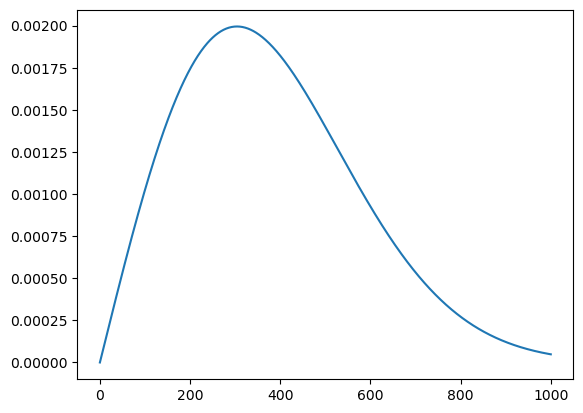

In [72]:
x = np.linspace(0, 1000, 1000)
y = diffDeflection(x)

fig, ax = plt.subplots(1, 1)

ax.plot(x, y)

In [154]:
def yield_func( theta):
    yield_hist = np.array([0, 10, 90, 100])
    sputterY = np.zeros_like(theta)
    indice = np.logical_and(theta > yield_hist[0], theta < yield_hist[1])
    indice |= np.logical_and(theta > yield_hist[2], theta < yield_hist[3])
    sputterY[indice] = 1
    return sputterY


In [155]:
yield_func(np.arange(100))

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [250]:
vel = np.array([1, 1, -2])

normal = np.array([0.1, 0, 1])
normal = normal/np.linalg.norm(normal)
print(np.linalg.norm(normal))
print(normal)
print(vel@normal)

velp = vel - 2*vel@normal*normal

print(velp)

1.0
[0.09950372 0.         0.99503719]
-1.8905706613989797
[1.37623762 1.         1.76237624]


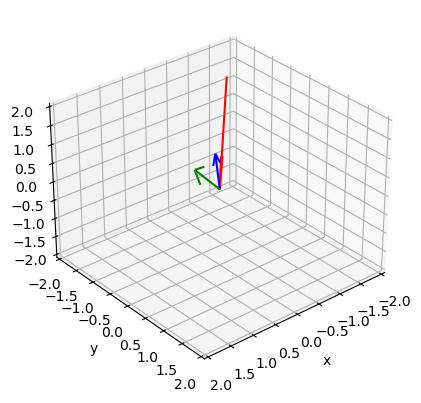

In [258]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
origin = np.zeros(3)
# Make the direction data for the arrows

ax.quiver(-vel[0],       -vel[1],    -vel[2], vel[0],       vel[1],    vel[2], color='red')
ax.quiver(origin[0], origin[1], origin[2], normal[0], normal[1], normal[2], color='blue')
ax.quiver(origin[0], origin[1], origin[2], velp[0], velp[1], velp[2], color='green')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=30, azim=50, roll=0)
plt.show()

In [314]:
N = 10
vel = np.array([1, 0, -2])
velN = np.zeros((N, 3))

normal = np.array([0.4, 0, 1])
normal = normal/np.linalg.norm(normal)
normalN = np.zeros((N, 3))
for i in range(N):
    velN[i] = vel
    normalN[i] = normal
velp = velN - 2*velN@normalN*normalN

Ut = velN - velN@normal*normal

tw1 = Ut/np.linalg.norm(Ut)
print(tw1)
print(np.linalg.norm(tw1))
tw2 = np.cross(tw1, normal)

print(tw2)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 3)

In [309]:
kB = 1.380649e-23
Al_m = 44.803928e-27
T = 100
N = 10
np.dot(np.random.randn(N), tw1)

ValueError: shapes (10,) and (3,) not aligned: 10 (dim 0) != 3 (dim 0)

In [306]:
kB = 1.380649e-23
Al_m = 44.803928e-27
T = 100
N = 10
U = np.sqrt(kB*T/Al_m)*(np.random.randn(N)*tw1 + np.random.randn(N)*tw2 - np.sqrt(-2*np.log((1-np.random.rand(N))))*normal)

ValueError: operands could not be broadcast together with shapes (10,) (3,) 

In [305]:
print(U)

[ -10.85392311  -94.05416338 -391.7431983 ]


In [296]:
np.random.randn(10)

array([-1.92983475, -0.63181178,  0.4142361 , -0.74856157, -1.01294495,
       -0.52180346, -0.44314008, -0.05644121,  1.09828999,  0.42828418])

In [73]:
N = 10
vel = np.array([-1, 0, -2])


normal = np.array([-0.4, 0, 1])
normal = normal/np.linalg.norm(normal)
normalN = np.zeros((N, 3))

velp = vel - 2*vel@normal*normal

Ut = vel - vel@normal*normal

tw1 = Ut/np.linalg.norm(Ut)
print(tw1)
print(np.linalg.norm(tw1))
tw2 = np.cross(tw1, normal)

print(tw2)

kB = 1.380649e-23
Al_m = 44.803928e-27
T = 100
N = 10
U = np.sqrt(kB*T/Al_m)*(np.random.randn()*tw1 + np.random.randn()*tw2 - np.sqrt(-2*np.log((1-np.random.rand())))*normal)

[-0.92847669  0.         -0.37139068]
0.9999999999999999
[0. 1. 0.]


In [74]:
N = 50

UN = np.zeros((N, 3))
for i in range(N):
    U = np.sqrt(kB*T/Al_m)*(np.random.randn()*tw1 + np.random.randn()*tw2 - np.sqrt(-2*np.log((1-np.random.rand())))*normal)
    UN[i] = U


UN = np.divide(UN.T, np.linalg.norm(UN, axis=1)).T
print(UN)

print(np.linalg.norm(UN, axis=1))

[[ 0.42009611  0.51276861 -0.74872398]
 [ 0.90655071  0.09795881 -0.41057262]
 [-0.3589007   0.50370205 -0.78579548]
 [ 0.10382744  0.44009351 -0.89192912]
 [ 0.07339323 -0.59918126 -0.79724228]
 [-0.31165199 -0.74938776 -0.58420118]
 [ 0.86089583 -0.10936691 -0.49688756]
 [-0.68846388  0.07052226 -0.72183385]
 [-0.08285499  0.91925966 -0.38483337]
 [ 0.34077769  0.91879027 -0.19923607]
 [ 0.36670057 -0.14831184 -0.91844123]
 [ 0.32395329 -0.79995106 -0.5051065 ]
 [-0.49728915 -0.33567787 -0.80001492]
 [-0.81408031 -0.01822639 -0.58046623]
 [ 0.69791812  0.59998719 -0.39105712]
 [ 0.07085323 -0.31303684 -0.94709438]
 [-0.29515464 -0.8171351  -0.49515044]
 [ 0.23980001 -0.70511956 -0.66730979]
 [ 0.93351457 -0.14121979 -0.32955654]
 [ 0.11610953 -0.92421451 -0.36379406]
 [ 0.0956667   0.952176   -0.29018744]
 [ 0.06849976  0.94772279 -0.31165575]
 [ 0.68139322 -0.72722893 -0.08271257]
 [ 0.54559886  0.18165674 -0.81812146]
 [-0.18679889  0.57140686 -0.79912475]
 [ 0.94483191  0.21563085

In [ ]:
@jit(nopython=True)
def reemission(vel, normal, particleMass):
    UN = np.zeros((vel.shape[0], 3))
    for i in range(vel.shape[0]):
        Ut = vel[i] - vel[i]@normal[i]*normal[i]
        tw1 = Ut/np.linalg.norm(Ut)
        tw2 = np.cross(tw1, normal)
        U = np.sqrt(kB*T/particleMass[i])*(np.random.randn()*tw1 + np.random.randn()*tw2 - np.sqrt(-2*np.log((1-np.random.rand())))*normal)
        UN[i] = U
    return -UN


In [4]:
N = 100
kB = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
Al_m = 26.98e-3 / 6.022e23  # Mass of aluminum atom in kg

vel = np.array([-1, 0, -2])

normal = np.array([-0.4, 0, 1])
normal = normal / np.linalg.norm(normal)

velp = vel - 2 * vel @ normal * normal

Ut = vel - vel @ normal * normal

tw1 = Ut / np.linalg.norm(Ut)
print(tw1)
print(np.linalg.norm(tw1))
tw2 = np.cross(tw1, normal)

# 向量化随机数生成
randn_tw1 = np.random.randn(N)[:, np.newaxis]
randn_tw2 = np.random.randn(N)[:, np.newaxis]
rand_log = np.sqrt(-2 * np.log(1 - np.random.rand(N)))[:, np.newaxis]

# 计算U
U = np.sqrt(kB * T / Al_m) * (randn_tw1 * tw1 + randn_tw2 * tw2 - rand_log * normal)

# 归一化U
UN = U / np.linalg.norm(U, axis=1)[:, np.newaxis]

print(UN)


[-0.92847669  0.         -0.37139068]
0.9999999999999999
[[ 0.80924429  0.01522534 -0.58727496]
 [-0.52064536 -0.06917746 -0.85096586]
 [ 0.90340119  0.42733107  0.03541818]
 [-0.50787282  0.095413   -0.85613174]
 [ 0.94364578 -0.14096987 -0.29943303]
 [-0.46722061 -0.05029298 -0.88270919]
 [-0.15835174  0.74537192 -0.64756886]
 [ 0.45716305 -0.15238193 -0.87623153]
 [-0.15792798  0.04995255 -0.98618634]
 [ 0.67229101 -0.67998807 -0.29264489]
 [ 0.13111784  0.10096663 -0.98621187]
 [-0.15325263  0.74430822 -0.65001454]
 [ 0.18444259 -0.63357808 -0.75137191]
 [ 0.13630347 -0.73763289 -0.66130106]
 [-0.76214739  0.33983013 -0.55104159]
 [ 0.11834118  0.46194175 -0.87897963]
 [ 0.08211503  0.95687426 -0.27865528]
 [ 0.16324939  0.81647018 -0.55382857]
 [ 0.92738446  0.02320065 -0.37338959]
 [ 0.4938627   0.22460226 -0.84003182]
 [-0.52131916 -0.27059424 -0.80932384]
 [-0.19515924 -0.74168736 -0.64172637]
 [-0.26197138  0.47990296 -0.83729573]
 [ 0.36698946  0.24656816 -0.896952  ]
 [-0.56

In [9]:
@jit(nopython=True)
def reemission(vel, normal):
    mass = 27 * 1.66e-27
    UN = np.zeros((vel.shape[0], 3))
    
    for i in range(vel.shape[0]):
        # 计算 Ut
        dot_product = vel[i, 0] * normal[i, 0] + vel[i, 1] * normal[i, 1] + vel[i, 2] * normal[i, 2]
        Ut = vel[i] - dot_product * normal[i]
        
        # 手动计算 Ut 的范数
        norm_Ut = np.sqrt(Ut[0]**2 + Ut[1]**2 + Ut[2]**2)
        
        # 计算 tw1 和 tw2
        tw1 = Ut / norm_Ut
        tw2 = np.cross(tw1, normal[i])
        
        # 计算新的速度向量 U
        U = np.sqrt(kB * T / mass) * (np.random.randn() * tw1 + np.random.randn() * tw2 - np.sqrt(-2 * np.log(1 - np.random.rand())) * normal[i])
        
        # 归一化后的 U
        UN[i] = U / np.sqrt(U[0]**2 + U[1]**2 + U[2]**2)
        
    return UN



vel = np.array([-1, 0, -2])

normal = np.array([-0.4, 0, 1])
normal = normal / np.linalg.norm(normal)

vel_matrix = np.zeros((N, 3))
vel_matrix[:] = vel
normal_matrix = np.zeros((N, 3))
normal_matrix[:] = normal

UN = reemission(vel_matrix, normal_matrix)

In [31]:
# @jit(nopython=True)
def DiffusionReflect(vel, normal):
    mass = 27*1.66e-27
    Ut = vel - vel@normal*normal
    tw1 = Ut/np.linalg.norm(Ut)
    tw2 = np.cross(tw1, normal)
    # U = np.sqrt(kB*T/particleMass[i])*(np.random.randn()*tw1 + np.random.randn()*tw2 - np.sqrt(-2*np.log((1-np.random.rand())))*normal)
    U = np.sqrt(kB*T/mass)*(np.random.randn()*tw1 + np.random.randn()*tw2 - np.sqrt(-2*np.log((1-np.random.rand())))*normal)
    UN = U / np.linalg.norm(U)
        # UN[i] = U
    return UN

N = 40
UN = np.zeros((N, 3))

for i in range(N):
    vel = np.array([-1, 0, -2])

    normal = np.array([0, 0, 1])
    normal = normal / np.linalg.norm(normal)
    UN[i,:] = DiffusionReflect(vel, normal)

# vel_matrix[:] = vel
# normal_matrix = np.zeros((N, 3))
# normal_matrix[:] = normal

# UN = reemission(vel_matrix, normal_matrix)

In [ ]:
def DiffusionReflect(vel, normal):
    mass = 27*1.66e-27
    Ut = vel - vel@normal*normal
    tw1 = Ut/np.linalg.norm(Ut)
    tw2 = np.cross(tw1, normal)
    # U = np.sqrt(kB*T/particleMass[i])*(np.random.randn()*tw1 + np.random.randn()*tw2 - np.sqrt(-2*np.log((1-np.random.rand())))*normal)
    U = np.sqrt(kB*T/mass)*(np.random.randn()*tw1 + np.random.randn()*tw2 - np.sqrt(-2*np.log((1-np.random.rand())))*normal)
    UN = U / np.linalg.norm(U)
        # UN[i] = U
    return UN

N = 40
UN = np.zeros((N, 3))

for i in range(N):
    vel = np.array([-1, 0, -2])

    normal = np.array([0, 0, 1])
    normal = normal / np.linalg.norm(normal)
    UN[i,:] = DiffusionReflect(vel, normal)

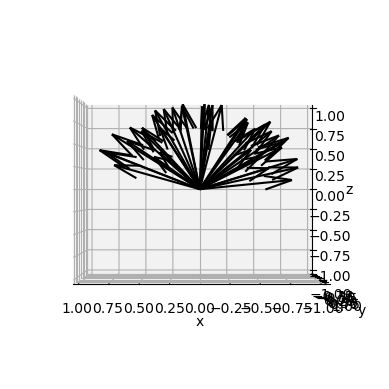

In [32]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
origin = np.zeros((N, 3))
# Make the direction data for the arrows


ax.quiver(origin[:, 0], origin[:, 1], origin[:, 2], -UN[:, 0], -UN[:,1], -UN[:,2], color='black')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0, azim=90, roll=0)
plt.show()

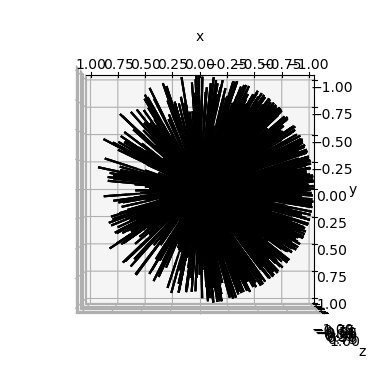

In [19]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
origin = np.zeros((N, 3))
# Make the direction data for the arrows


ax.quiver(origin[:, 0], origin[:, 1], origin[:, 2], -UN[:, 0], -UN[:,1], -UN[:,2], color='black')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=90, azim=90, roll=0)
plt.show()

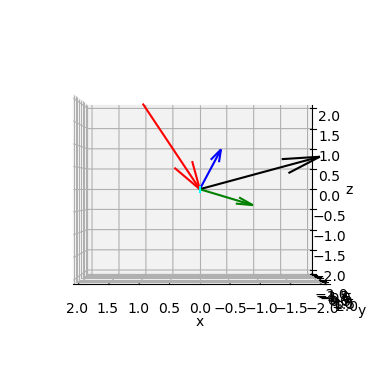

In [20]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
origin = np.zeros(3)
# Make the direction data for the arrows

ax.quiver(-vel[0],       -vel[1],    -vel[2], vel[0],       vel[1],    vel[2], color='red')
ax.quiver(origin[0], origin[1], origin[2], normal[0], normal[1], normal[2], color='blue')
ax.quiver(origin[0], origin[1], origin[2], velp[0], velp[1], velp[2], color='black')
ax.quiver(origin[0], origin[1], origin[2], tw1[0], tw1[1], tw1[2], color='green')
ax.quiver(origin[0], origin[1], origin[2], tw2[0], tw2[1], tw2[2], color='cyan')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0, azim=90, roll=0)
plt.show()